<a href="https://colab.research.google.com/github/LeyloJohnny/First-ML/blob/main/Advances_3_or_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.0MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 194kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 12.1MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 12.8MB 284kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

#What functions do we have?

Initialize parameters:

In [12]:
#function to initialize random parameters, important: keep track of gradients!
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

Matrix multiplication:

In [13]:
#matrix multiplication used to make predictions (= parameters) based on weights and bias (y=w*x+b)
def linear1(xb): return xb@weights + bias

Loss function:

In [14]:
#update weights using loss function 
def mnist_loss(predictions, targets):
  #apply sigmoid function to ensure that values are between 0 and 1
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

#Defining a dataset:

**IN GENERAL**

In [8]:
#collection defined as a range between 0 and 15
coll = range(15)
#define dataset
#containing all numbers from 0 to 15 (coll) randomly shuffeled in tensors consisting of 5 numbers each (batch_size)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [9]:
#make a really simple dataset of number/letter tupels:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [10]:
#pass a Dataset to a DataLoader
dl = DataLoader(ds, batch_size=6, shuffle=True)
#output: batches which are themselves tuples of tensors representing batches of independent and dependent variables
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

**EXAMPLE WITH 3 AND 7**

In [ ]:
#download a sample of MNIST that contains images of 3 and 7 digits
path = untar_data(URLs.MNIST_SAMPLE)

In [17]:
#hide
Path.BASE_PATH = path

In [18]:
#sort dataset to make sure we get the same order of files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [19]:
#make tensors for all threes and all sevens
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [20]:
#stack images --> make a 3D tensor from all tensors to get pixel average afterwards
#divide by 255 to get numbers between 0 and 1
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [22]:
#create tensors from validation "valid" dataset
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

#check if the shape is correct
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [23]:
#define training set and convert 3-rank tensor into 2-rank tensor
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [24]:
#label data, 3s are given the label 1--> define as train_y
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [25]:
#combine values to build a dataset consisting of a list of tuples (x, y) using zip
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [26]:
#define the validation set similarly to the training set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

#Make the model:

**Overview of workflow**

for x,y in dl:

> pred = model(x)

> loss = loss_func(pred, y)

> loss.backward()

> parameters -= parameters.grad * lr
  

**Initialize parameters**

In [15]:
weights = init_params((28*28,1))
bias = init_params(1)

**Create dataloader from dataset**

In [27]:
#Dataloader from training set
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [28]:
#Dataloader from validation set
valid_dl = DataLoader(valid_dset, batch_size=256)

In [29]:
#create mini batch of size 4 for training
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

**Make predictions**

In [30]:
#predictions based on our linear equation linear1
preds = linear1(batch)
preds

tensor([[-2.8015],
        [-2.9294],
        [ 1.3709],
        [-1.8300]], grad_fn=<AddBackward0>)

**Calculate loss**

In [31]:
#predictions based on our linear equation linear1
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7391, grad_fn=<MeanBackward0>)

**Calculate gradients**

In [32]:
loss.backward()
#print out relevant results
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0147), tensor([-0.0957]))

**ALL IN ONE FUNCTION**

In [34]:
#this function makes predictions based on a model, calculates the loss, and calculates the gradients
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

Test the function with our model:

In [35]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0293), tensor([-0.1914]))

In [36]:
#but the gradients change if we call the function again
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0440), tensor([-0.2870]))

The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [37]:
weights.grad.zero_()
bias.grad.zero_();

**UPDATE WEIGHTS AND BIASES**

In [46]:
#function for one training epoch, afterwards gradients are reset to 0
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
#check the accuracy?
(preds>0.0).float() == train_y[:4]

**Accuracy function**

In [39]:
#apply sigmoid function
#find out how many labels were predicted correctly
#return the mean of the float made from the True/False list
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [40]:
#test the model using the accuracy function
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

**Validate function**

Based on all batches

In [41]:
#get accuracy based on all batches and return mean value
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [44]:
#test the model based on our validation epoch
validate_epoch(linear1)

0.3033

In [47]:
#now that's our starting point
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4962

Train and validate a few times:

In [48]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4991 0.5718 0.6005 0.8525 0.9232 0.9412 0.9471 0.953 0.9574 0.9608 0.9618 0.9652 0.9666 0.9701 0.9725 0.9725 0.974 0.9745 0.975 0.9755 

Yaaaay! It gets better :)

#Adding a Nonlinearity

In [49]:
#define a neural network consisting of two linear functions and a nonlinear max function in between
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

*res.max(tensor(0.0))* is called a rectified linear unit (ReLU)

It replaces every negative number with a zero.

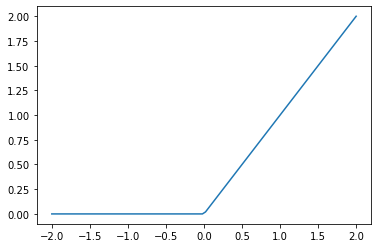

In [52]:
#yup, that's it
plot_function(F.relu);

In [67]:
#initialize all weight and bias parameters
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

#Universal approximation theorem

In [68]:
#simple neural network
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

nn.Sequential is a module that returns a list of all the parameters of all the modules it contains

In [69]:
#validation dataset
dls = DataLoaders(dl, valid_dl)

In [70]:
#define a learner (the model), based on the dataset, the neural network, the optimization function, the loss function, and the metrics
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
#train/fit the model (learner)
learn.fit(40, lr=lr)

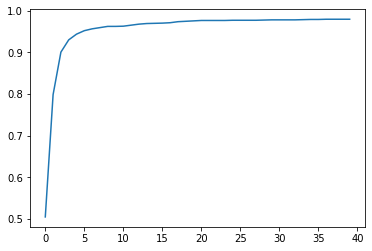

In [72]:
#plot the learning progress
plt.plot(L(learn.recorder.values).itemgot(2));

In [73]:
learn.recorder.values[-1][2]

0.9793915748596191

What we have: 
- A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
- A way to find the best set of parameters for any function (stochastic gradient descent)


In [74]:
#add more layers to the model (resnet18)
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.072407,0.006777,0.997547,03:15
